#  Machine Vision Coursework 1


In [2]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

## Task A: Load the color images and binary mask images

In [3]:
# Load the color images and binary mask images
color_files = sorted(glob.glob("apples/*.jpg"))
mask_files = sorted(glob.glob("apples/*.png"))

ColorImgs = []
MaskImgs = []

# Load images and masks
threshold = 0.5
for color_file, mask_file in zip(color_files, mask_files):
    # Load color image
    color_img = plt.imread(color_file)
    ColorImgs.append(color_img/255)  # Normalise the image to train faster and load faster

    # Load mask image and convert to binary mask
    mask_img = plt.imread(mask_file)
    MaskImgs.append((mask_img[:, :, 1] > threshold).astype(int))

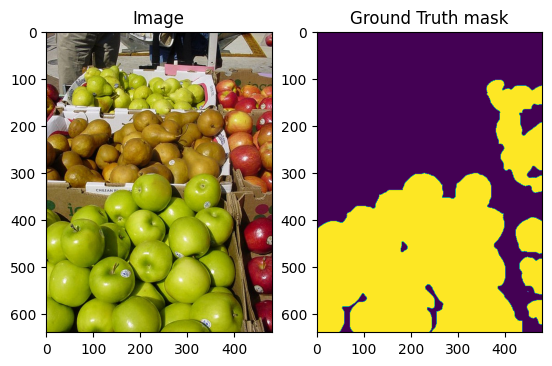

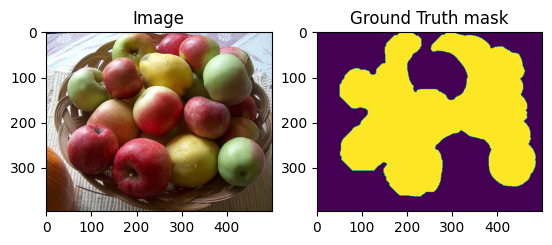

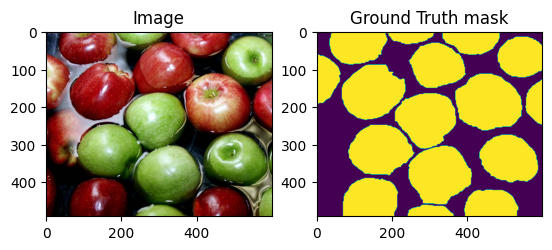

In [4]:
# Plot the test image and the ground truth mask for training plots      
for i in range(len(ColorImgs)):    
    _, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(ColorImgs[i])
    ax1.set_title('Image')
    ax2.imshow(MaskImgs[i])
    ax2.set_title('Ground Truth mask')

## Task B: Use MOG to distinguish apple vs non-apple pixels

In [6]:
apple_pixel_list = []
non_apple_pixel_list = []

for image in range(len(MaskImgs)):
    for row in range(MaskImgs[image].shape[0]):
        for column in range(MaskImgs[image].shape[1]):
            #Know to what list the pixel is getting appended to
            if MaskImgs[image][row,column] == 0: #Pixel where there is no apple
                non_apple_pixel_list.append(ColorImgs[image][row,column,:])
            else: #Pixel where there is an apple
                apple_pixel_list.append(ColorImgs[image][row,column,:])

#Convert them to numpy arrays:
pixel_apple = np.transpose(np.array(apple_pixel_list)) #Transpose them to have D by N
pixel_non_apple = np.transpose(np.array(non_apple_pixel_list)) #Transpose them to have D by N

print(pixel_apple.shape)
print(pixel_non_apple.shape)

(3, 425703)
(3, 374597)


We first create 2 empty lists to store all the RGB values of apple pixels and non-apple pixels. Loop through all the color images and mask images, and for each image we will iterate over the row and column so we can iterate through each pixel in the image. If the mask value is not 0 this indicates that it is an apple pixel, which the RBG values will be added to the apple list, vice versa.
Once we collect all the pixels, we need to convert into numpy arrays and take a transpose, so we will result into (3 * total number pixels) dimensions. last two code output the results for apple and non-apple pixels.

In [7]:
def calcGaussianProb(data,gaussMean,gaussCov):    #Helper function from practical exercises

    nDim,nData = data.shape
    
    centered_data = data - gaussMean[:,None] #[:, None] can make dimensions match

    # Compute the inverse and determinant of the covariance matrix
    cov_inv = np.linalg.pinv(gaussCov)
    cov_det = np.linalg.det(gaussCov)
    
    # Compute the normalization factor
    normalization = 1 / (np.sqrt((2 * np.pi) ** nDim * cov_det))

    # Compute the exponent term for each data point
    exponent = -0.5 * np.sum(centered_data * (cov_inv @ centered_data), axis=0)

    # Calculate the Gaussian probability density
    like = normalization * np.exp(exponent)

    return like

In [8]:
def mixGaussLikelihood(data, mixGaussEst, log=True):    #Helper function from practical exercises

    nDims, nData = data.shape

    # Initialize likelihood array for all data points
    likelihoods = np.zeros(nData)

    # Iterate over each Gaussian component and accumulate contributions to the likelihood
    for k in range(mixGaussEst['k']):
        weight_k = mixGaussEst['weight'][k]
        mean_k = mixGaussEst['mean'][:, k]
        cov_k = mixGaussEst['cov'][:, :, k]

        # Calculate the likelihood of the data points under the k-th Gaussian component
        gaussian_likelihood = calcGaussianProb(data, mean_k, cov_k)

        # Accumulate weighted likelihood contribution from the k-th Gaussian component
        likelihoods += weight_k * gaussian_likelihood

    # Return the log likelihood or likelihoods based on `return_log`
    if log == True:
        log_likelihood = np.sum(np.log(likelihoods))
        return log_likelihood
    else:
        return likelihoods

In [9]:
def fitMixGauss(data, k):   

    nDims, nData = data.shape                                                                                        
                                                                                                                     
                                                                                                      
    responsibility = np.zeros(shape=(k, nData))                                                                    
                                                                                                                     
    # we will initialize the values to random values
    mixGaussEst = dict()
    mixGaussEst['d'] = nDims
    mixGaussEst['k'] = k
    mixGaussEst['weight'] = (1 / k) * np.ones(shape=(k))
    mixGaussEst['mean'] = 2 * np.random.randn(nDims, k)
    mixGaussEst['cov'] = np.zeros(shape=(nDims, nDims, k))
    for cGauss in range(k):
        mixGaussEst['cov'][:, :, cGauss] = 2.5 + 1.5 * np.random.uniform() * np.eye(nDims)
    
    # get the current loglike
    log_initial = mixGaussLikelihood(data, mixGaussEst)
    log_Like = []
    log_Like.append(log_initial)
    
    nIter = 30
     
    
    for cIter in range(nIter):
        
        # ===================== =====================
        # Expectation step
        # ===================== =====================  
            
        for i in range(mixGaussEst['k']):
            responsibility[i] = mixGaussEst['weight'][i] * calcGaussianProb(data,mixGaussEst['mean'][:,i], mixGaussEst['cov'][:,:,i])
        
        responsibility = responsibility/np.sum(responsibility, axis=0)

        # ===================== =====================
        # Maximization Step
        # ===================== ===================== 
                                                                            
        for cGauss in range(k):                                                                                                                            
            mixGaussEst['weight'][cGauss] = np.sum(responsibility[cGauss, :])/np.sum(responsibility)
            # lamda_k = sum_i(r_ik)/sum(r_ij)
                          
            mixGaussEst['mean'][:,cGauss] = responsibility[cGauss,:].reshape(1,nData) @ data.T /np.sum(responsibility[cGauss, :])
            # mu_k = sum_i(r_ik*x_i)/sum_i(r_ik)
            
            # diff = X_i - mu_k
            diff = data - mixGaussEst['mean'][:,cGauss][:,None]
            mixGaussEst['cov'][:,:,cGauss] = responsibility[cGauss]*diff@diff.T / np.sum(responsibility[cGauss, :])
            # cov_k = sum_i(rik*diff*diff.T)/sum_i(r_ik)
       
        log_like = mixGaussLikelihood(data, mixGaussEst)
        log_Like.append(log_like)
        # Here i add a stopping rule. When the log likes becomes stable
        # it means we can stop training the model
        if(abs(log_Like[cIter] - log_Like[cIter+1]) < 1):
             break
        else:
             continue
                                                                                                                  
    return mixGaussEst,log_Like 

In [10]:
#In this case, we use k = 3
appleMixGaussEst,apple_log_like = fitMixGauss(pixel_apple,3)
nonAppleMixGaussEst,nonApple_log_like = fitMixGauss(pixel_non_apple,3)

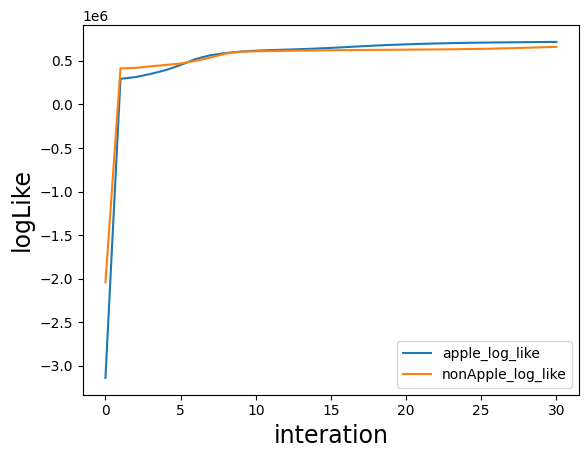

In [11]:
plt.plot(apple_log_like, label= 'apple_log_like')
plt.plot(nonApple_log_like, label= 'nonApple_log_like')
plt.legend()
plt.xlabel('interation', fontsize=17)
plt.ylabel('logLike', fontsize=17)
plt.show()

By applying helper functions that we defined in part 1 of the coursework. We compare apple's loglikelihood with non-apple's loglikelihood. The plot shows that after 30 iterations. the non-apple's loglikehood is still a little lower and not converge to apple's loglikelihood. However, it becomes more stable after nearly 5-10 iterations.
In this case we choose k=3 due to each pixel has 3 features. Therefore, to improve our model, we can manually choose higher value of k, such as 4 or 5 but we need to know that this can cause overfitting for training data.

## Task C: Generate figures and show pixel's posterior probability

In [12]:
#Load the color images in testApples using same method in Task A.
images = sorted(glob.glob("testApples/*.jpg"))
test_images_list = []
for image in images:
    im = plt.imread(image)
    test_images_list.append(im/255)

In [13]:
def posterior_prob(image,priorApple,priorNonApple):
    posteriorApple = []
    for i in range(len(image)):
        im = image[i]  
        imY, imX, imZ = im.shape
        img = im.reshape(imY*imX,imZ).T 
        # calculate MixGauss_like
        likeApple = mixGaussLikelihood(img, appleMixGaussEst,log = False)
        likeNonApple = mixGaussLikelihood(img, nonAppleMixGaussEst,log = False)
        # convert posterior back to shape(imY, imX)
        posterior = ((likeApple * priorApple)/(likeApple * priorApple + likeNonApple * priorNonApple)).reshape(imY, imX)
        posteriorApple.append(posterior)
            
    return posteriorApple

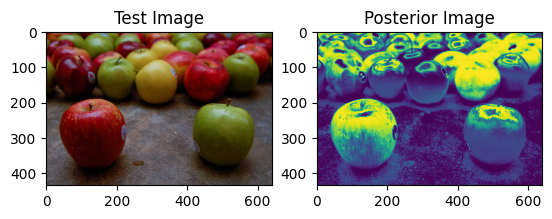

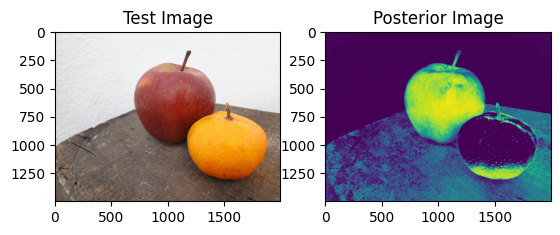

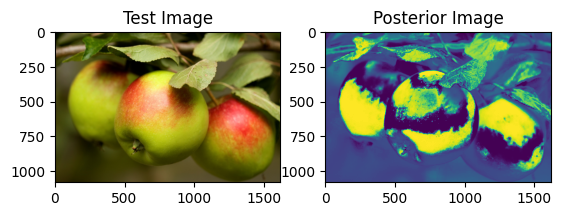

In [14]:
# Calculate prior 
# The prior is calculated by counting the number of data in positive dataset.
priorApple = pixel_apple.shape[1]/(pixel_non_apple.shape[1] + pixel_apple.shape[1])
priorNonApple = 1 - priorApple
posteriorApple = posterior_prob(test_images_list,priorApple,priorNonApple)


for i in range(len(test_images_list)):
# display the test image and the posterior image
    _, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(test_images_list[i])
    ax1.set_title('Test Image')
    ax2.imshow(posteriorApple[i])
    ax2.set_title('Posterior Image')
    
plt.show()

We now calculate the posterior probability of "testApples". The posterior image in the right shows the probability that each pixel belongs to the apple class. Yellow regions in the posterior images correspond to high probabilities of being apples, whereas purple regions correspond to low probabilities. Three posterior images depicts that model does not identify yellow apples well and classify them as non-apples. 
The performance varies depending on the complexity of the background—the simpler the background, the better the model is at distinguishing apples from the rest. To improve this, we need to consider more complex models or more advanced color spaces.

## Task D: Apply ROC curve

In [15]:
#Load the mask images in testApples.
test_Mask_files = sorted(glob.glob("testApples/*.png"))

test_MaskImgs = []
for myFile in test_Mask_files:
    im = plt.imread(myFile)
    test_MaskImgs.append((im[:, :, 1] > threshold).astype(int))

In [16]:
def ROC_curve(posterior,mask,threshold_size):
    threshold = np.arange(0,1,threshold_size) # a range of threshold
    FPR = [] # false positive rate = 1 - TNR = FP/N   (N negative instances for some condition)
    TPR = [] # true positive rate = 1 - FNR = TP/P    (P positive instances)
    D,N = posterior.shape
    
    for i in threshold:
        # Intial counts
        TP = 0 # True Positives: apple and recognized as apple
        TN = 0 # True Negatives: non-apple and recognized as not apple
        FP = 0 # False Positives: apple and recognized as not apple
        FN = 0 # False Negatives: non-apple and recognized as apple
            
        for d in range(D):  
            for j in range(N):        
                if((mask[d,j] == 1) and (posterior[d,j] >= i)):
                    TP += 1
                elif ((mask[d,j] == 0) and (posterior[d,j] < i)):
                    TN += 1                    
                elif ((mask[d,j] == 1) and (posterior[d,j] < i)):
                    FP += 1
                elif ((mask[d,j] == 0) and (posterior[d,j] >= i)):
                    FN += 1

        # If denominator = 0
        if (FP+TN == 0):
            fpr = 0
        else:
            fpr = FP/(FP+TN)
            
        if (TP+FN == 0):
            tpr = 0
        else:
            tpr = TP/(TP+FN)
            
        FPR.append(fpr)
        TPR.append(tpr)
    
    return FPR, TPR


All the formulas are from Wikipedia. (https://en.wikipedia.org/wiki/Receiver_operating_characteristic)

Text(0.5, 1.0, 'Posterior Image')

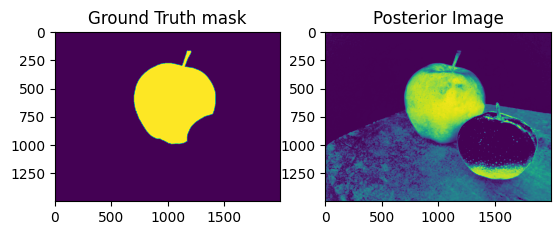

In [17]:
f, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(test_MaskImgs[0])
ax1.set_title('Ground Truth mask')
ax2.imshow(posteriorApple[1])
ax2.set_title('Posterior Image')

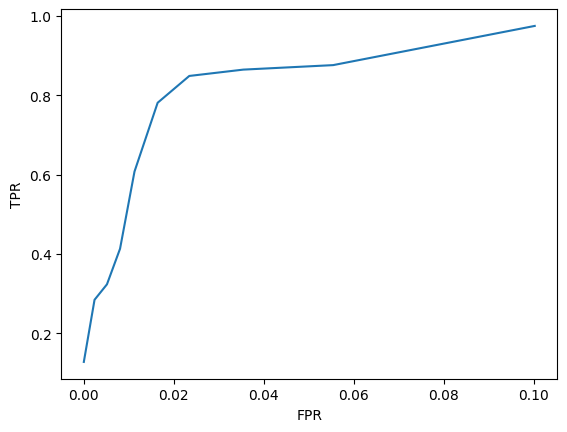

In [18]:
FPR, TPR = ROC_curve(posteriorApple[1],test_MaskImgs[0],0.1)
plt.plot(FPR, TPR)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

The "FPR vs TPR" graph shows that as the threshold changes, TPR starts rising quickly and reching values close to 1 (indicating that the model correctly identifies most apple pixels). The curve is almost close to the top-left corner, which is a good indicator of high model performance.
Hence, The model performs very well at distinguishing apple pixels from non-apple pixels.

## Task E: Make Ground-truth mask for apples

In [44]:
new_color_files = sorted(glob.glob("newApples/*.jpg"))

new_colorImgs = []

for myFile in new_color_files:
    new_color_img = plt.imread(myFile)
    new_colorImgs.append(new_color_img/255)

In [45]:
new_mask_files = sorted(glob.glob("newApples/*.png"))

new_maskImgs = []

threshold = 0.5
for mymaskFile in new_mask_files:
    mask_img = plt.imread(mymaskFile)
    new_maskImgs.append((mask_img[:, :, 1] > threshold).astype(int))

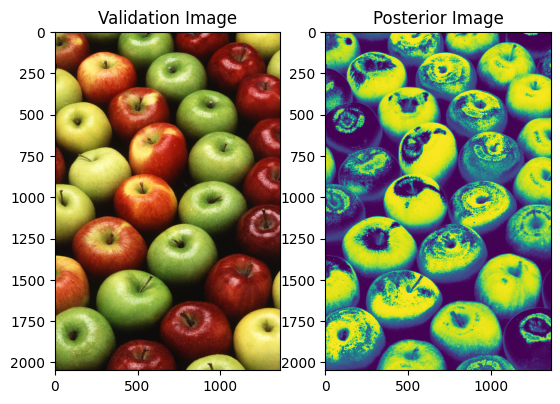

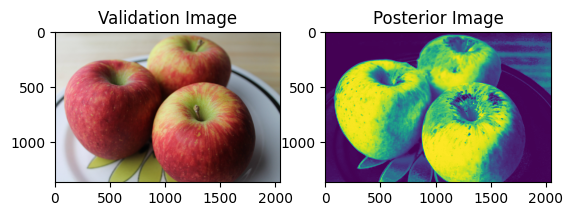

In [46]:
posteriorApple_new = posterior_prob(new_colorImgs,priorApple,priorNonApple)
for i in range(len(new_colorImgs)):
# display the test image and the posterior image
    _, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(new_colorImgs[i])
    ax1.set_title('Validation Image')
    ax2.imshow(posteriorApple_new[i])
    ax2.set_title('Posterior Image')

plt.show()

The 2 posterior images show that most of the apples are identified, but still have similar problems like previous tasks(i.e. Yellow apples and shadow parts are not identified.)

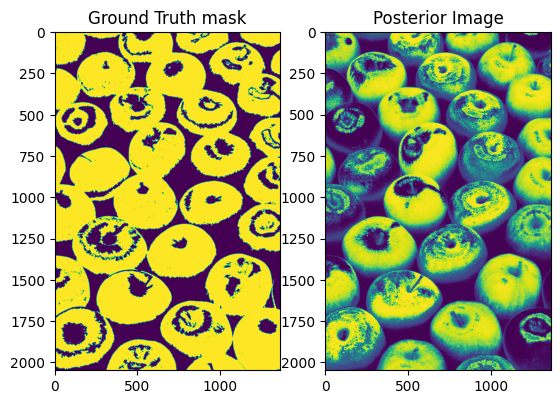

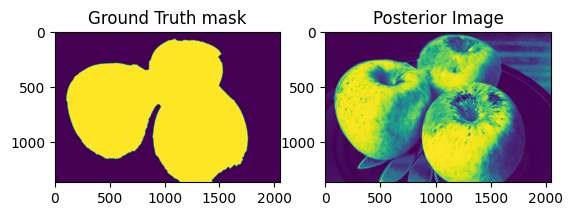

In [49]:
# Plot the newApples ground truth and the posterior images      
for i in range(len(new_maskImgs)):    
    _, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(new_maskImgs[i])
    ax1.set_title('Ground Truth mask')
    ax2.imshow(posteriorApple_new[i])
    ax2.set_title('Posterior Image')

The 2 ground truth mask png pictures in "newApples" are made by windows paint, and I'm not very good at using this tool, but I tried :) 

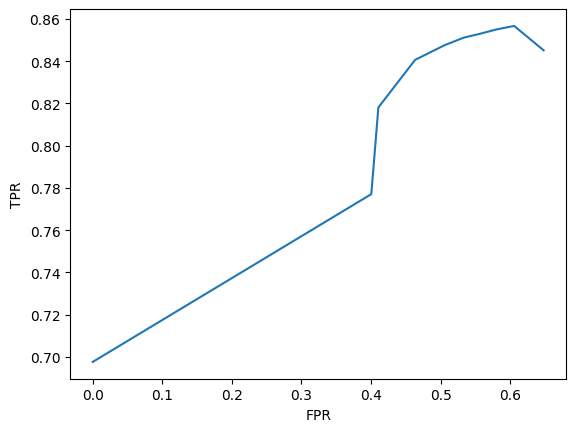

In [50]:
# Forming ROC curve
FPR, TPR = ROC_curve(posteriorApple_new[0],new_maskImgs[0],0.1)
plt.plot(FPR, TPR)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

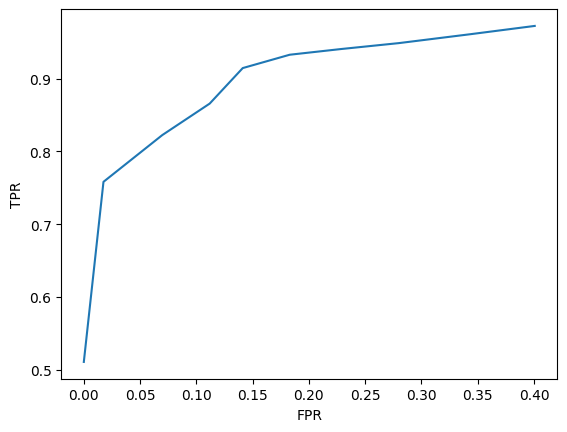

In [51]:
FPR, TPR = ROC_curve(posteriorApple_new[1],new_maskImgs[1],0.1)
plt.plot(FPR, TPR)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

The first ROC curve shows quite bad performance. Even it starts with high TPR value(around 0.7), but as FPR increases to 0.86 it starts decreases and this could be caused by overlap between apple and non-apple areas makes it hard to maintain good performances. Meaning overfitting might occur also my Ground Truth Mask is bad and need some adjustions.

The second ROC curve also starts with high TPR value and continue to main increasing trend and reaching (0,1). Compare with the first curve, this curve clearly perform better, but it could be due to there are only 3 apples in this graph and the first graph has around 20 apples.


## Task F

Training Set: Used to fit the model and learn the parameters.
Validation Set: Used to tune hyperparameters and prevent overfitting.
Test Set: Used to evaluate the model after training is complete.

If we do not use all three sets, there is a risk that your model will perform well only on the specific data it has seen (due to overfitting) and will struggle with generalization. Having a dedicated validation and test set ensures that the model is robust and generalises well to unseen data.

In our case, we first train our model using "apples". Then use "testApples" to evaluate the performance of our model and the ROC curve shows good performances(Task D). However, our model does not detecty shadow and the Yellow apple well. Which could be a reason why in "newApple" the ROC curve does not perform well when there are 20 apples with different color.

To improve our model, we can add more apple files for training. Or try different validation techniques such as using "Cross-validation" to avoid overfitting or create separate validation set to tune model and hyperparameters. 